# Alzheimer's disease identification from brain x-ray images

MLUB Night - Oct 26, 2023

## Model Training

## 1. Install and import packages

In [60]:
# %%capture
!pip install sagemaker -U
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.6/915.6 KB 5.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.195.0-py2.py3-none-any.whl size=1221693 sha256=4139976dbff76e8b9a576c9ae0a01a2681af092396dd1e69b7c3aa48ea8abec5
  Stored in directory: /root/.cache/pip/wheels/4b/c5/f7/ee31f3a6c29736120026c2dfca7535c93c72edfe8e30ed205f
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.194.0
    Uninstalling sagemaker-2.194.0:
      Successfully uninstalled sagemaker-2.194.0


In [220]:
import sagemaker

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

## 2. Setup

In [190]:
BUCKET = "mlub-dementia-demo"

In [191]:
role = sagemaker.get_execution_role()

inputs = f"s3://{BUCKET}/Alzheimer_s Dataset/"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [192]:
role

'arn:aws:iam::655329371831:role/service-role/AmazonSageMaker-ExecutionRole-20230227T103736'

## 3. Train the model

In [193]:
hyperparameters = {
    "lr": '0.0021',
    "epochs":"5"
}
hyperparameters

{'lr': '0.0021', 'epochs': '5'}

In [194]:
output_path = f"s3://{BUCKET}/outputs/"

In [97]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                            "train.save_interval": "10",
                                                            "eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [195]:
estimator = PyTorch(entry_point = 'train_model1.py',
                    role = role,
                    instance_count=1,
                    instance_type = 'ml.c5.4xlarge',
                    py_version = 'py38',
                    framework_version = '1.11.0',
                    hyperparameters = hyperparameters,
                    profiler_config = profiler_config, 
                    debugger_hook_config = debugger_config,
                    output_path=output_path,
                    rules = rules ) 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
estimator.fit({'train': inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-10-25-19-01-28-382


2023-10-25 19:01:28 Starting - Starting the training job...
2023-10-25 19:01:53 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-10-25 19:02:53 Downloading - Downloading input data......
2023-10-25 19:03:53 Training - Downloading the training image...
2023-10-25 19:04:28 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-25 15:04:51,028 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-25 15:04:51,029 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-25 15:04:51,031 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-10-25 15:04:51,041 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups suc

In [110]:
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [86]:
# trial = create_trial(estimator.latest_job_debugger_artifacts_path())

In [87]:
# trial = create_trial(s3_output_path)

In [221]:
estimator = sagemaker.estimator.Estimator.attach('pytorch-training-2023-10-25-19-01-28-382')

s3_output_path = estimator.latest_job_debugger_artifacts_path()
rules_path = estimator.debugger_rules

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml

2023-10-25 19:29:29 Starting - Preparing the instances for training
2023-10-25 19:29:29 Downloading - Downloading input data
2023-10-25 19:29:29 Training - Training image download completed. Training in progress.
2023-10-25 19:29:29 Uploading - Uploading generated training model
2023-10-25 19:29:29 Completed - Training job completed


In [222]:
trial = create_trial("s3://mlub-dementia-demo/outputs/pytorch-training-2023-10-25-19-01-28-382/debug-output/")

[2023-10-26 12:44:04.121 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:409 INFO s3_trial.py:42] Loading trial  at path s3://mlub-dementia-demo/outputs/pytorch-training-2023-10-25-19-01-28-382/debug-output/


In [223]:
trial.tensor_names

<bound method Trial.tensor_names of <smdebug.trials.s3_trial.S3Trial object at 0x7f133d9ea370>:(
    name=,
    path=s3://mlub-dementia-demo/outputs/pytorch-training-2023-10-25-19-01-28-382/debug-output/,
    steps=[0, 132, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 457, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 590, 619, 621, 623, 625, 627, 629, 631, 633, 635, 637, 639, 641, 643, 645, 647, 781, 783, 785, 787, 789, 791, 793, 795, 797, 799, 801, 803, 805, 807, 809, 811, 813, 815, 817, 819, 821, 823, 825, 827, 829, 831, 833, 835, 837, 839, 841, 843, 845, 847, 849, 851],
    collections=['weights', 'losses', 'default', 'all', 'biases', 'gradients', 'CrossEntropyLoss_output_0', 'relu_input'],
    tensor_names=['CrossEntropyLoss_output_0', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


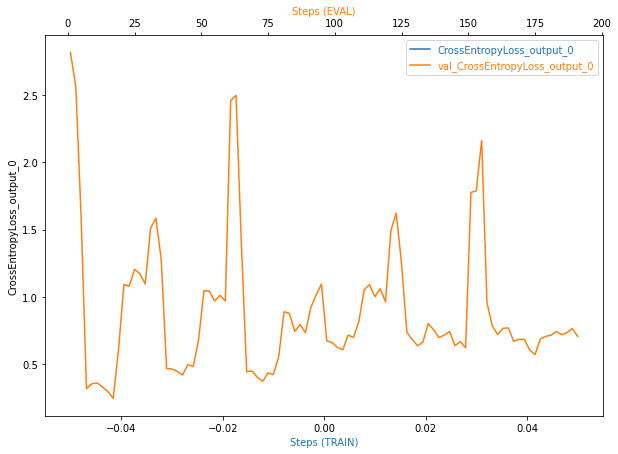

In [224]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

plot_tensor(trial, "CrossEntropyLoss_output_0")

The end of the notebook